In [1]:
# import necessary imports
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import pymysql
pymysql.install_as_MySQLdb()

from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists

# Tukeys pairwise test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from urllib.parse import quote_plus as urlquote

In [2]:
df_combined = pd.read_csv('Data/tmdb_results_combined.csv.gz')
display(df_combined.head())
print("Number of rows : ", len(df_combined))

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.112,2009.0,PG


Number of rows :  53019


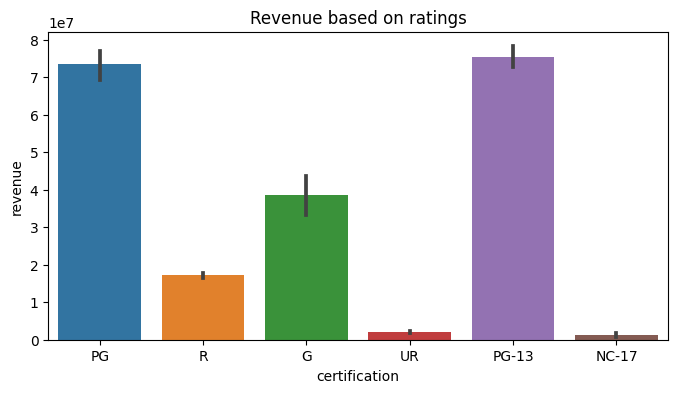

In [3]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.barplot(data=df_combined, x='certification', y='revenue', ci=55, ax=ax)
plt.title("Revenue based on ratings");
plt.savefig('Visuals/barplot_Revenue-Ratings.png', pad_inches=1)

In [4]:
# Lets get a list of ratings
list_of_ratings = df_combined['certification'].value_counts().index
list_of_ratings

Index(['R', 'PG-13', 'UR', 'PG', 'G', 'NC-17'], dtype='object')

In [5]:
# In this dictionary we will store the ratings as the keys and their rows as the values
my_dfs = {}
for i in list_of_ratings:
    my_dfs[i] = df_combined.loc[df_combined['certification']==i, 'revenue']    

In [6]:
my_dfs.keys()

dict_keys(['R', 'PG-13', 'UR', 'PG', 'G', 'NC-17'])

# Do the MPAA ratings of a movie affect how much revenue the movie generates?

 - $H_0:$ The MPAA ratings have no effect how much revenue the movie generates.
 - $H_1:$ The MPAA rating does effect how much revenue the movie makes.
 
 Data Type : Numeric (Revenue)
 
 Samples: More than 2 samples/groups
 
 Test: ANOVA and/or Tukey
 
 Assumptions: 
    - No significant outliers
    - Equal variance
    - Normality

# Remove outliers

In [7]:
# Test an example before running on all Series

# temp = my_dfs['R']
# zscores = stats.zscore(temp)
# outliers = np.abs(zscores) > 3
# temp_clean = temp[outliers == False]
# temp_clean

In [8]:
# function that removes outliers from a Series
def is_outlier(temp, name): 
    zscores = stats.zscore(temp)
    outliers = np.abs(zscores) > 3
    temp_clean = temp[outliers == False]
    print('Rating ', name, '\nNumber of outliers : ', outliers.sum(), '\n')
    
    return temp_clean

In [9]:
# Test the above function
# x = is_outlier(my_dfs['PG-13'])
# x

In [10]:
cleaned_data = {}
for i, df in my_dfs.items():
    temp = is_outlier(df, i)
    if (len(temp) > 7):
        cleaned_data[i] = temp
    else:
        print("For rating", i, "there are too few entries to perform normality testing.")

Rating  R 
Number of outliers :  112
Rating  PG-13 
Number of outliers :  80
Rating  UR 
Number of outliers :  28
Rating  PG 
Number of outliers :  37
Rating  G 
Number of outliers :  10
Rating  NC-17 
Number of outliers :  2


# Check for normality

In [11]:
for i,data in cleaned_data.items():
    result = stats.normaltest(data)
    print('For ratings', i, 'the result from the normal test is', result.pvalue)
    if(result.pvalue < .05):
        print("Significant")
        print("The number of samples we have is :", len(data), "\n")
    else:
        print("Not Significant\n")

For ratings R the result from the normal test is 0.0
Significant
The number of samples we have is : 5502 

For ratings PG-13 the result from the normal test is 0.0
Significant
The number of samples we have is : 2906 

For ratings UR the result from the normal test is 0.0
Significant
The number of samples we have is : 2879 

For ratings PG the result from the normal test is 2.3516523247501652e-166
Significant
The number of samples we have is : 1265 

For ratings G the result from the normal test is 2.7577691161312906e-66
Significant
The number of samples we have is : 387 

For ratings NC-17 the result from the normal test is 5.228544631680267e-39
Significant
The number of samples we have is : 135 



Despite having a significant p-value for all of our tests, which means we failed the normality test, we can still proceed as planned because we have more then 15 samples in each group.

# Equal Variance

In [12]:
result = stats.levene(*cleaned_data.values())
print(result)

LeveneResult(statistic=273.197450345645, pvalue=8.80098127344915e-279)


Because we have a significant p-value we must conclude that our data is not equally variant.

# Final Test

In [13]:
# Final test is kruskal
result = stats.kruskal(*cleaned_data.values())
print(result)

KruskalResult(statistic=1764.3856914319545, pvalue=0.0)


Because we have a significant p-value we reject our null hypothesis and support our alternative hypthesis that "The MPAA rating does effect how much revenue the movie generates".

# Which ratings effect revenue

## Post-Hoc Multiple Comparison Test

In [14]:
# Make an empty list for saving our dataframes
tukeys_dfs = []

for rating, df in cleaned_data.items():
    temp = pd.DataFrame({'Data': df, 'Rating': rating})
    tukeys_dfs.append(temp)

# Make on giant dataframe that holds all the dataframes
tukeys_data = pd.concat(tukeys_dfs)
tukeys_data

,Data,Rating
5,0.0,R
6,0.0,R
7,0.0,R
11,14904.0,R
16,105983.0,R
...,...,...
49151,100000.0,NC-17
49666,0.0,NC-17
49723,0.0,NC-17
49968,0.0,NC-17


In [15]:
values = tukeys_data['Data']
labels = tukeys_data['Rating']

# Perform test
tukeys_result = pairwise_tukeyhsd(values, labels)
print(tukeys_result.summary())

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
group1 group2    meandiff    p-adj      lower          upper      reject
------------------------------------------------------------------------
     G  NC-17 -21231680.8639 0.0084  -38950051.027  -3513310.7009   True
     G     PG  27302772.5155   -0.0  17005667.0247  37599878.0063   True
     G  PG-13  28027983.4232   -0.0  18436109.4577  37619857.3887   True
     G      R -11166034.2157 0.0084  -20488179.936  -1843888.4954   True
     G     UR -21240703.9225    0.0 -30837862.2819  -11643545.563   True
 NC-17     PG  48534453.3794   -0.0  32484907.2042  64583999.5546   True
 NC-17  PG-13  49259664.2871   -0.0  33653204.1789  64866124.3954   True
 NC-17      R  10065646.6482 0.4285  -5376501.8996   25507795.196  False
 NC-17     UR     -9023.0586    1.0 -15618731.5605  15600685.4434  False
    PG  PG-13    725210.9077 0.9993  -5245663.1794   6696084.9948  False
    PG      R -38468806.7312   -0.0 -43995984.3134 

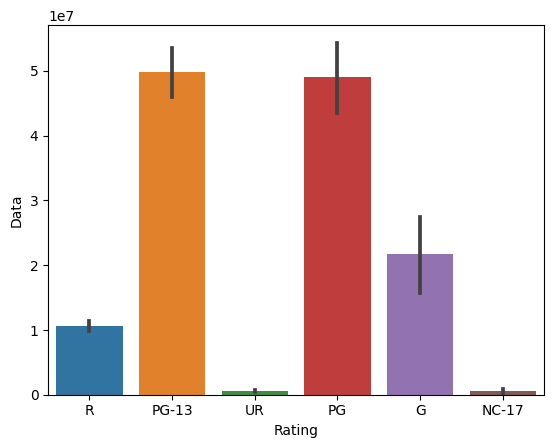

In [16]:
# Plot results from tukeys test
ax = sns.barplot(data=tukeys_data, x='Rating', y='Data')
plt.savefig('Visuals/barplot_Tukeys_Data.png', pad_inches=1)

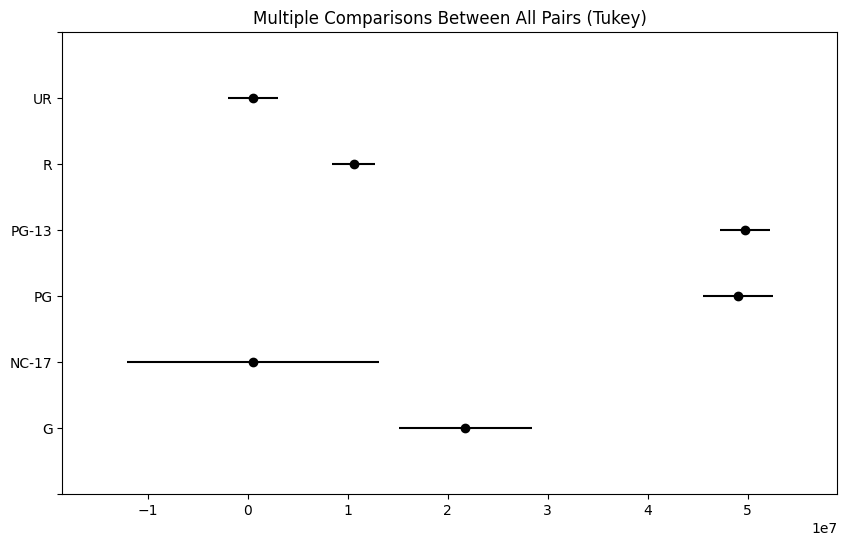

In [17]:
tukeys_result.plot_simultaneous();
plt.savefig('Visuals/tukeys_plot_simultaneous.png', pad_inches=1)